In [3]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pickle
file = open("data_risk2_dummy","rb")
X_train = pickle.load(file)
y_train = pickle.load(file)
X_test = pickle.load(file)
y_test = pickle.load(file)
file.close()

In [5]:
X_train.head(2)

,menopaus_0,menopaus_1,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,...,nrelbc_1,nrelbc_2,brstproc_0,brstproc_1,lastmamm_0,lastmamm_1,surgmeno_0,surgmeno_1,hrt_0,hrt_1
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [6]:
y_train.value_counts()

0    109536
1      4293
Name: cancer, dtype: int64

In [7]:
X_test.head(2)

,menopaus_0,menopaus_1,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,...,nrelbc_1,nrelbc_2,brstproc_0,brstproc_1,lastmamm_0,lastmamm_1,surgmeno_0,surgmeno_1,hrt_0,hrt_1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [8]:
#rfecol = ['agegrp_3', 'agegrp_4', 'agegrp_5', 'agegrp_6', 'agegrp_7', 'agegrp_8','agegrp_9', 'agegrp_10', 'density_1', 
#          'density_2', 'race_2', 'race_4', 'nrelbc_1', 'nrelbc_2', 'lastmamm_0']
rfecol = ['menopaus_0', 'agegrp_2', 'agegrp_3', 'agegrp_4', 'agegrp_5',
       'agegrp_6', 'agegrp_7', 'agegrp_8', 'agegrp_9', 'agegrp_10',
       'density_1', 'density_4', 'race_2', 'race_3', 'race_4', 'race_5',
       'hispanic_0', 'hispanic_1', 'bmi_3', 'bmi_4', 'agefirst_1',
       'agefirst_2', 'nrelbc_0', 'nrelbc_2', 'lastmamm_1']
    
X_train=X_train[rfecol]
X_test=X_test[rfecol]

# Model Building on Cancer Data

## <span style="color:blue">Model 3 - Weighted XGBoost</span>

### Default Hyperparameters

Let's first fit a random forest model with default hyperparameters.

In [9]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

def model_stats(X, y, y_pred, model):

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix ->")
    print(cm)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    
    print("Accuracy:",accuracy_score(y, y_pred))

    sensi = TP / float(TP+FN)
    speci = TN / float(TN+FP)
    
    # Let's see the sensitivity of our model
    print("Sensitivity:", sensi)

    # Let us calculate specificity
    print("Specificity:", speci)

    print("Average:", (sensi+speci)/2)
    
    # Let us calculate precision
    print("Precision",TP / float(TP+FP))
    print("MCC ", metrics.matthews_corrcoef(y, y_pred))
    print("F1 ", metrics.fbeta_score(y, y_pred, beta = 1))
    print("F2 ", metrics.fbeta_score(y, y_pred, beta = 2))
    print("F3 ", metrics.fbeta_score(y, y_pred, beta = 3))
    
    # Predicting probability for roc_auc
    pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    

In [10]:
# Importing random forest classifier from sklearn library
from xgboost import XGBClassifier

In [11]:
xgb = XGBClassifier(random_state = 100)

# fit
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
# Let's check the evaluation metrics of our default model

# Making predictions
y_pred_train_def = xgb.predict(X_train) # For train data
y_pred_test_def = xgb.predict(X_test) # For test data

#### Evaluating model on imbalanced train data with default parameters

Confusion Matrix ->
[[109536      0]
 [  4293      0]]
Accuracy: 0.9622855335635031
Sensitivity: 0.0
Specificity: 1.0
Average: 0.5
Precision nan
MCC  0.0
F1  0.0
F2  0.0
F3  0.0
ROC-AUC : 0.78


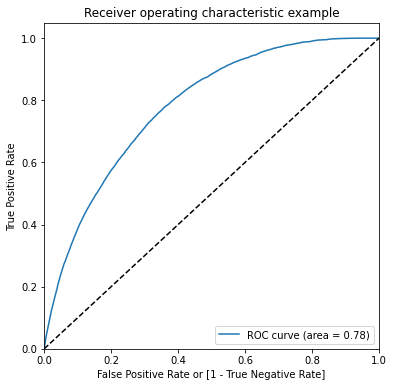

In [13]:
# For train
model_stats(X_train, y_train, y_pred_train_def, xgb)

#### Evaluating model on imbalanced test data with default parameters

Confusion Matrix ->
[[57930     0]
 [ 1571     0]]
Accuracy: 0.9735970824019764
Sensitivity: 0.0
Specificity: 1.0
Average: 0.5
Precision nan
MCC  0.0
F1  0.0
F2  0.0
F3  0.0
ROC-AUC : 0.71


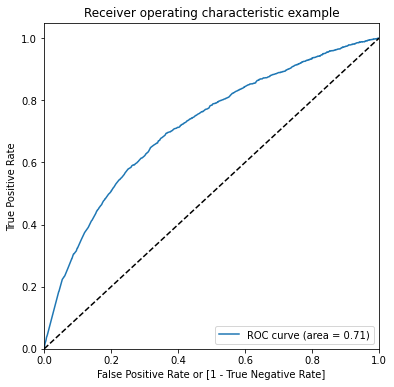

In [14]:
# For test
model_stats(X_test, y_test, y_pred_test_def, xgb)

Training the model with scale_pos_weight parameter

In [15]:
# We can now find the optimal hyperparameters using GridSearchCV.
from sklearn.model_selection import GridSearchCV,StratifiedKFold

# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

In [16]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'scale_pos_weight': [125, 150, 175, 200, 225]
}

xgb = XGBClassifier(
 n_estimators = 200,
 learning_rate =0.1,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.2min finished


best accuracy 0.5937108069855351
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=125,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [17]:
# We can now find the optimal hyperparameters using GridSearchCV.
from sklearn.model_selection import GridSearchCV,StratifiedKFold

# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Create the parameter grid based on the results of random search 
param_grid = {
    'scale_pos_weight': [75, 100, 125, 250]
}

xgb = XGBClassifier(
 n_estimators = 200,
 learning_rate =0.1,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.4min finished


best accuracy 0.6212618512266292
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=75,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [18]:
# We can now find the optimal hyperparameters using GridSearchCV.
from sklearn.model_selection import GridSearchCV,StratifiedKFold

# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Create the parameter grid based on the results of random search 
param_grid = {
    'scale_pos_weight': [25,40,60,75]
}

xgb = XGBClassifier(
 n_estimators = 200,
 learning_rate =0.1,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.4min finished


best accuracy 0.6821632113509011
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=25,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [19]:
# We can now find the optimal hyperparameters using GridSearchCV.
from sklearn.model_selection import GridSearchCV,StratifiedKFold

# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Create the parameter grid based on the results of random search 
param_grid = {
    'scale_pos_weight': [5,15,20,25]
}

xgb = XGBClassifier(
 n_estimators = 200,
 learning_rate =0.1,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.5min finished


best accuracy 0.6821632113509011
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=25,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


### Hyperparameter Tuning : Grid Search to Find Optimal Hyperparameters

We can now use GridSearchCV to find multiple optimal hyperparameters together.

The following hyperparameters are present in a random forest classifier. Note that most of these hypereparameters are actually of the decision trees that are in the forest.
- **max_depth** : integer or None, optional (default=None)The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- **min_samples_leaf** : int, float, optional (default=1)The minimum number of samples required to be at a leaf node:**
- **min_samples_split** : int, float, optional (default=2)The minimum number of samples required to split an internal node:**
- **n_estimators**: integer, optional (default=10): The number of trees in the forest.
- **criterion**: string, optional (default=”gini”)The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.
- **max_features** : int, float, string or None, optional (default=”auto”)The number of features to consider when looking for the best split:

In [20]:
# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [150,250,300]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=25,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.1min finished


best accuracy 0.6850054154635995
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=25,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [21]:
# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [50, 100]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=25,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   29.2s finished


best accuracy 0.6849844512770761
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=25,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


we choose n_estimators as 150

In [22]:
# Create the parameter grid based on the results of random search 
param_grid = {
   # 'max_depth': [5,7,9],
    'min_child_weight' : [1,3,5]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 gamma=0,
 max_depth=5,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=25,
 seed=27)

xgb.fit(X_train,y_train)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=150, n_jobs=4, nthread=4,
                                     num_parallel_tree=1, random_state=27,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=25, seed=27,
                                     subsample=0.8, tree_method='e

In [23]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.6865452466974207
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=25,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [24]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [6,7,8]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 gamma=0,
 min_child_weight=3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=25,
 seed=27)

xgb.fit(X_train,y_train)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.9min finished


best accuracy 0.6828243418611274
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=25,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [25]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'gamma': [0,.1,.2,.3,.4,.5]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=5,
 min_child_weight=3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=25,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.8min finished


best accuracy 0.6865452466974207
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=25,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [26]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=5,
 min_child_weight=3, 
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=25,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.5min finished


best accuracy 0.6865452466974207
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=25,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [27]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=25,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid,  scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.5min finished


best accuracy 0.6865452466974207
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=25,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [28]:
xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 reg_alpha=0,
 scale_pos_weight=25,
 seed=27)

# Fit the grid search to the data
xgb.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=25,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

Confusion Matrix ->
[[75245 34291]
 [ 1232  3061]]
Accuracy: 0.6879266267822787
Sensitivity: 0.7130211972979269
Specificity: 0.6869431054630442
Average: 0.6999821513804856
Precision 0.08195009638038124
MCC  0.16227729605383093
F1  0.1470044423100012
F2  0.28070207614995235
F3  0.4028214610009344
ROC-AUC : 0.78


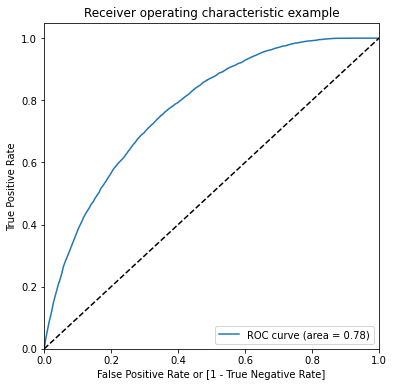

In [29]:
#### Model evaluation on train data

# Predicting on test dataframe using predict
y_pred_train = xgb.predict(X_train)
model_stats(X_train, y_train, y_pred_train, xgb)

Confusion Matrix ->
[[35500 22430]
 [  458  1113]]
Accuracy: 0.6153341960639317
Sensitivity: 0.7084659452577976
Specificity: 0.6128085620576558
Average: 0.6606372536577267
Precision 0.047275198572824195
MCC  0.10533857952762224
F1  0.08863582065780042
F2  0.18657592114527108
F3  0.2953664879783451
ROC-AUC : 0.72


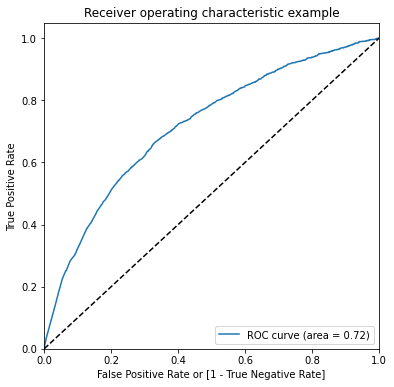

In [30]:
#### Model evaluation on test data

# Predicting on test dataframe using predict

y_pred_test = xgb.predict(X_test)
#y_pred_test=(xgb.predict_proba(X_test)[:,1] > 0.51).astype(bool)

model_stats(X_test, y_test, y_pred_test, xgb)